# Label side

In [1]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-01-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

candles.shape

(2630880, 6)

In [2]:
np.save("data/btc_1m.npy", candles)

In [2]:
import numpy as np

candles = np.load("data/btc_1m.npy")
candles = candles[candles[:, 5] > 0]
candles.shape

(2628380, 6)

In [3]:
from scipy import stats
from custom_indicators.toolbox.bar.entropy_bar_v2 import EntropyBarContainer

window = 134
window_vol_t = 78
window_vol_ref = 1341
entropy_threshold = 26.96225407898441

entropy_bar_container = EntropyBarContainer(
    window, window_vol_t, window_vol_ref, entropy_threshold
)
entropy_bar_container.update_with_candle(candles)
merged_bar = entropy_bar_container.get_entropy_bar()
close_arr = merged_bar[:, 2]
ret = np.log(close_arr[1:] / close_arr[:-1])
standard = (ret - ret.mean()) / ret.std()
kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
kurtosis

10.533179843047023

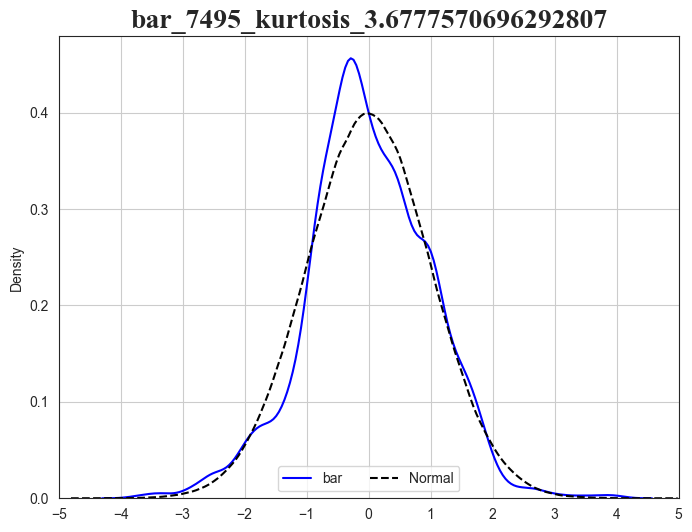

In [16]:
from custom_indicators.utils.plot import plot_kde

plot_kde(merged_bar[:, 2], lag=120)

In [4]:
L = 5  ### 1阶与X阶
mix = 3  ### GMM mix参数

close_arr = merged_bar[:, 2]
high_arr = merged_bar[:, 3][L:]
low_arr = merged_bar[:, 4][L:]

log_return = np.log(close_arr[1:] / close_arr[:-1])[L - 1 :]
log_return_L = np.log(close_arr[L:] / close_arr[:-L])
HL_diff = np.log(high_arr / low_arr)

In [5]:
X = np.column_stack([HL_diff, log_return_L, log_return])

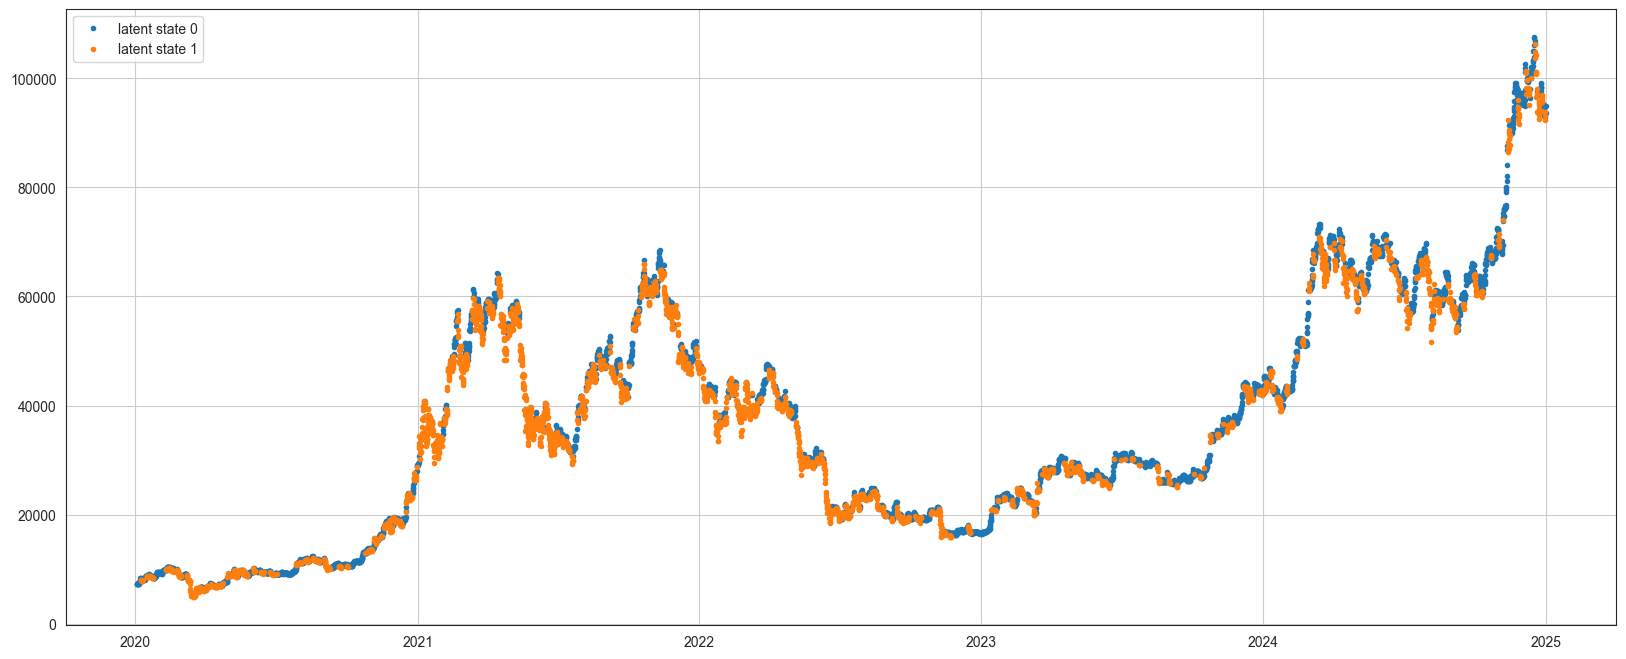

In [6]:
from hmmlearn.hmm import GMMHMM
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from jesse.helpers import timestamp_to_time

datelist = np.asarray(
    [pd.Timestamp(timestamp_to_time(i)) for i in merged_bar[:, 0][L:]]
)
closeidx = merged_bar[:, 2][L:]

assert len(datelist) == len(closeidx)
assert len(datelist) == len(X)

gmm = GMMHMM(
    n_components=2, n_mix=mix, covariance_type="diag", n_iter=1000, random_state=42
)
gmm.fit(X)
latent_states_sequence = gmm.predict(X)
sns.set_style("white")
plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    plt.plot(datelist[state], closeidx[state], ".", label="latent state %d" % i, lw=1)
    plt.legend()
    plt.grid(1)

In [7]:
np.unique(latent_states_sequence, return_counts=True)

(array([0, 1]), array([4816, 2674]))

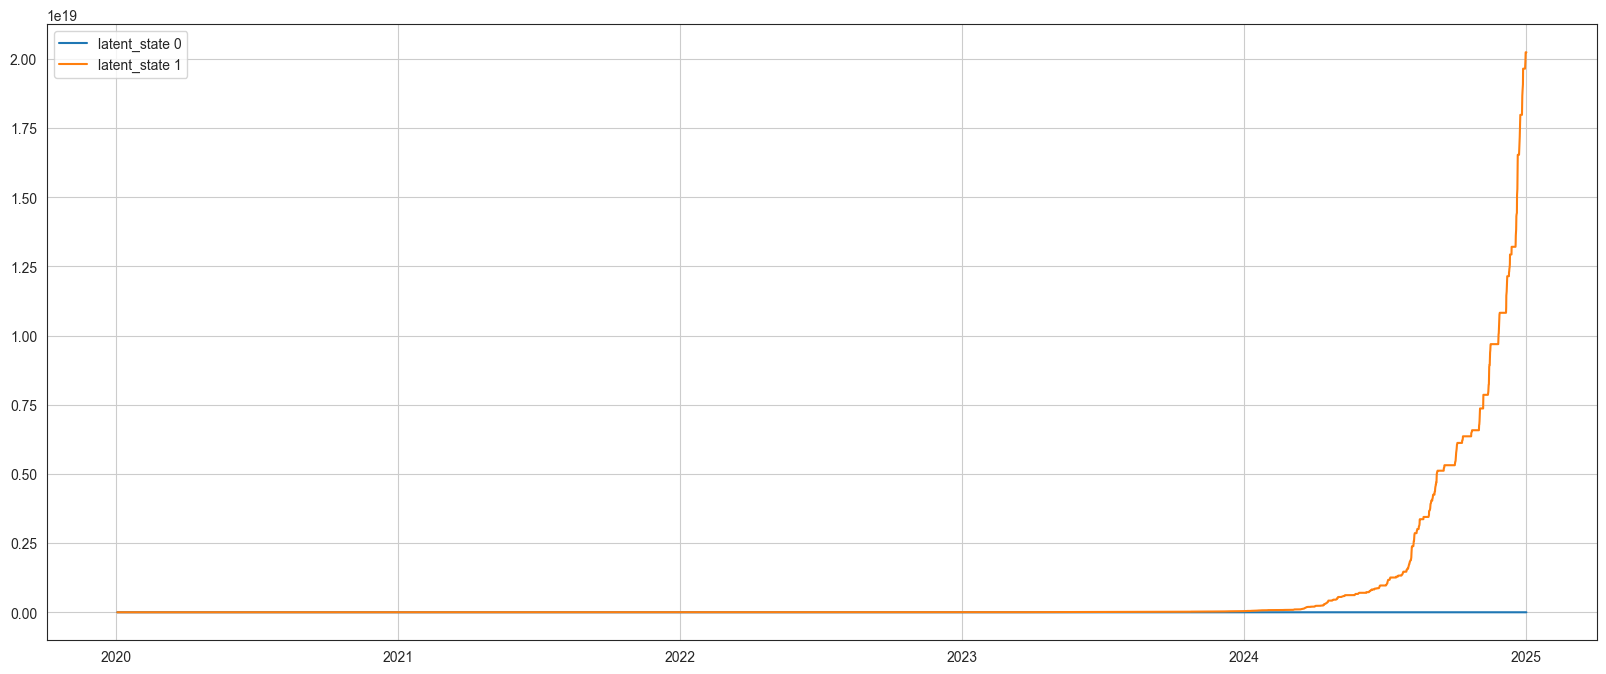

In [8]:
data = pd.DataFrame(
    {
        "datelist": datelist,
        "logreturn": np.abs(log_return),
        "state": latent_states_sequence,
    }
).set_index("datelist")

plt.figure(figsize=(20, 8))
for i in range(gmm.n_components):
    state = latent_states_sequence == i
    idx = np.append(0, state[1:])
    data["state %d_return" % i] = data.logreturn.multiply(idx, axis=0)
    plt.plot(np.exp(data["state %d_return" % i].cumsum()), label="latent_state %d" % i)
    plt.legend(loc="upper left")
    plt.grid(1)

In [ ]:
import numpy as np

In [3]:
from jesse import helpers

from custom_indicators.toolbox.bar.dollar_bar import build_dollar_bar
from strategies.BinanceMLV2.config import DOLLAR_BAR_THRESHOLD_MID

print(DOLLAR_BAR_THRESHOLD_MID)

tp = helpers.date_to_timestamp("2025-04-05")

label_bar = build_dollar_bar(trading_1m, DOLLAR_BAR_THRESHOLD_MID)

print(label_bar.shape)

5352685516.211758
(4642, 6)


In [4]:
from custom_indicators.toolbox.labeler.zigzag_labeler import zigzag

res = zigzag(label_bar[:, 2], 0.05)
np.unique(res, return_counts=True)

(array([-1,  1]), array([2117, 2525]))

In [5]:
label = np.column_stack((label_bar, res))
label

array([[ 1.57799880e+12,  6.94495000e+03,  7.84890000e+03, ...,
         6.86344000e+03,  7.17060163e+05, -1.00000000e+00],
       [ 1.57840344e+12,  7.84861000e+03,  7.81022000e+03, ...,
         7.73300000e+03,  6.62080816e+05, -1.00000000e+00],
       [ 1.57861170e+12,  7.81023000e+03,  8.45870000e+03, ...,
         7.67000000e+03,  6.63591450e+05,  1.00000000e+00],
       ...,
       [ 1.74421926e+12,  7.91491000e+04,  8.15480000e+04, ...,
         7.91491000e+04,  7.02868230e+04,  1.00000000e+00],
       [ 1.74422094e+12,  8.15493000e+04,  8.20514000e+04, ...,
         8.11917000e+04,  6.55216160e+04,  1.00000000e+00],
       [ 1.74422592e+12,  8.20523000e+04,  8.25880000e+04, ...,
         8.19801000e+04,  6.48128060e+04,  1.00000000e+00]])

In [6]:
np.save("data/label_side.npy", label[label[:, 0] <= tp])
print(label.shape)
print(label[label[:, 0] <= tp].shape)

(4642, 7)
(4614, 7)


In [7]:
from jesse import utils

df_dollar_bar = utils.numpy_candles_to_dataframe(
    label_bar[label_bar[:, 0] <= tp], name_date="time"
)
df_dollar_bar["zigzag"] = res[label_bar[:, 0] <= tp]
df_dollar_bar.head(1)

,time,open,close,high,low,volume,zigzag
2020-01-02 21:00:00,2020-01-02 21:00:00,6944.95,7848.9,8014.91,6863.44,717060.163,-1


In [8]:
from lightweight_charts import Chart

chart = Chart(inner_width=1, inner_height=0.8)
chart2 = chart.create_subchart(position="bottom", width=1, height=0.2, sync=True)

chart.set(df_dollar_bar[["time", "open", "high", "low", "close", "volume"]])

line = chart2.create_line(name="zigzag", style="dotted")
line.set(df_dollar_bar[["time", "zigzag"]])

chart.show(block=True)

RuntimeError: asyncio.run() cannot be called from a running event loop

# Label meta

In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from strategies.BinanceMLV2.config import SIDE_ALL

label_side_1h = np.load("data/label_side.npy")
print(label_side_1h.shape)
print(np.unique(label_side_1h[:, 6], return_counts=True))

df_features = pd.read_parquet("data/features_600m.parquet")
print(df_features.shape)

side_model = lgb.Booster(model_file="strategies/BinanceMLV2/model/model_side.txt")
side_model_pred_prob = side_model.predict(df_features[SIDE_ALL])
df_features["side_model_res"] = side_model_pred_prob
side_model_pred = np.where(side_model_pred_prob > 0.5, 1, -1)
print(np.unique(side_model_pred, return_counts=True))

(4614, 7)
(array([-1.,  1.]), array([2100, 2514]))
(4614, 15051)
(array([-1,  1]), array([2078, 2536]))


In [2]:
meta_label = (side_model_pred.astype(int) == label_side_1h[:, 6].astype(int)).astype(
    int
)
np.unique(meta_label, return_counts=True)

(array([0, 1]), array([ 802, 3812]))

In [3]:
label_meta_1h = label_side_1h.copy()
label_meta_1h[:, 6] = meta_label
np.save("data/label_meta.npy", label_meta_1h)